In [1]:
from transformers import Speech2TextFeatureExtractor, Speech2TextModel
import torch
import torch.nn.functional as F
import torchaudio
import numpy as np

from auditory_cortex.regression import transformer_regression
from auditory_cortex.dataset import Neural_Data

dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
# dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)


model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")
reg = transformer_regression(dir, subject)

for param in model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/akamsali/anaconda3/envs/research_env/lib/pyt

In [2]:
def get_beta_eta(sent=[1], layer=0):
    # train_list = np.arange(1,451).tolist()
    z_vals_train, n_vals_train = reg.get_layer_values_and_spikes(layer=layer, win=80, sent_list=sent)
    # print(z_vals_train.shape, n_vals_train.shape)
    beta = np.linalg.solve(z_vals_train.T.dot(z_vals_train), (z_vals_train.T).dot(n_vals_train))
    return beta, n_vals_train, z_vals_train

In [3]:
layers = ["encoder.conv.conv_layers.0","encoder.conv.conv_layers.1","encoder.layers.0.fc2",
			"encoder.layers.1.fc2","encoder.layers.2.fc2","encoder.layers.3.fc2",
			"encoder.layers.4.fc2","encoder.layers.5.fc2","encoder.layers.6.fc2",
			"encoder.layers.7.fc2","encoder.layers.8.fc2","encoder.layers.9.fc2"]

In [4]:
from gradient_extraction.get_gradients import GetGradient
import matplotlib.pyplot as plt
# layer = 3

# aud = neural_data.audio(12)
# spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features
# optimizer = torch.optim.Adam([spect], lr=10)
# get_opt_input = GetGradient(model, optimizer)

# get_opt_input.get_opt_input(spect, layers[layer], iterations=100)


# # plt.figure()
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))


# ax1.imshow(spect.detach().numpy().T)
# ax1.set_xlabel("Time")
# ax1.set_ylabel("Frequency")
# ax2.plot(get_opt_input.loss_list)
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Frequency")
# plt.show()

In [5]:
# # get_opt_input.beta 
# beta_z = torch.zeros_like(get_opt_input.hook.output_f)
# print(beta_z)
# beta_z[:,:, 0] = get_opt_input.hook.output_f[:,:,0]

In [6]:
# layer = 3
spect_grad_data = []
loss_list = []
aud = neural_data.audio(12)
for n, l in enumerate(layers):
# for i in range(1, 11):
    print(n, l)
    spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features
    optimizer = torch.optim.Adam([spect], lr=10)
    get_opt_input = GetGradient(model, optimizer)

    get_opt_input.get_opt_input(spect, l, iterations=100)


    # modified = dream(spect, model, "encoder.conv.conv_layers.0", iterations=10, lr=10)
    with torch.no_grad():
    #     # modified.squeeze_(0)``
        spect.squeeze_(0)

    spect_grad_data.append(spect.grad.data[0].numpy())
    loss_list.append(get_opt_input.loss_list)

    # plt.figure()
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    # ax0.imshow(feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T)
    # ax = ax0.gca()
    # ax.invert_yaxis()
    # ax0.set_xlabel("Time")
    # ax0.set_ylabel("Frequency")
    # plt.show()
    # plt.figure()
    # ax1.imshow(spect.detach().numpy().T)
    # # ax = ax1.gca()
    # # ax.invert_yaxis()
    # ax1.set_xlabel("Time")
    # ax1.set_ylabel("Frequency")
    # # plt.show()

    # # plt.figure()
    # ax2.plot(get_opt_input.loss_list)
    # ax2.set_xlabel("Time")
    # ax2.set_ylabel("Frequency")
    # plt.show()

0 encoder.conv.conv_layers.0


/home/akamsali/anaconda3/envs/research_env/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


1 encoder.conv.conv_layers.1
2 encoder.layers.0.fc2
3 encoder.layers.1.fc2
4 encoder.layers.2.fc2
5 encoder.layers.3.fc2
6 encoder.layers.4.fc2
7 encoder.layers.5.fc2
8 encoder.layers.6.fc2
9 encoder.layers.7.fc2
10 encoder.layers.8.fc2
11 encoder.layers.9.fc2


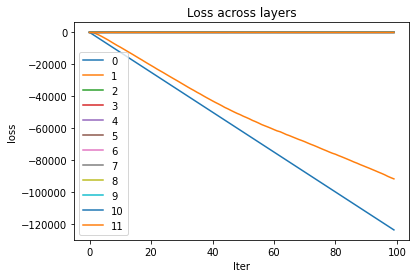

In [7]:
for s, l in enumerate(loss_list):
    plt.plot(l, label=s)

plt.legend()
plt.title("Loss across layers")
plt.xlabel("Iter")
plt.ylabel("loss")
plt.show()

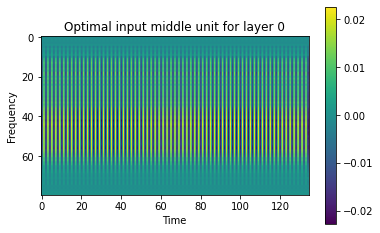

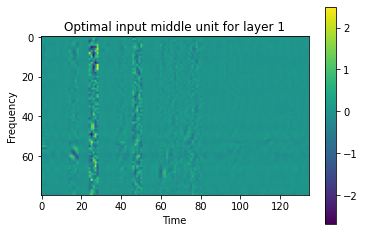

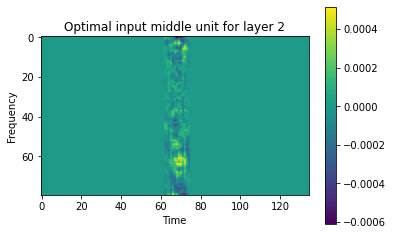

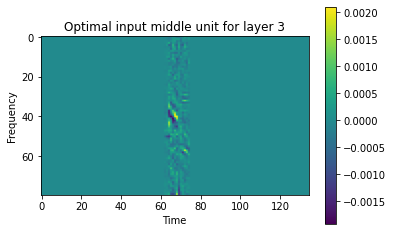

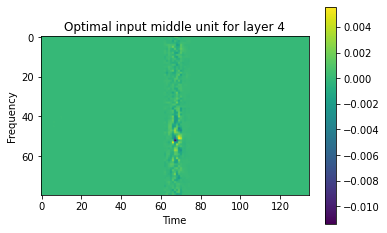

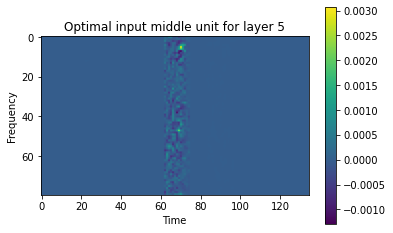

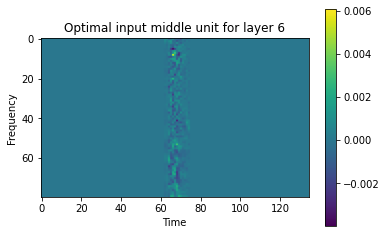

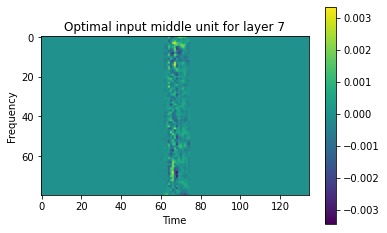

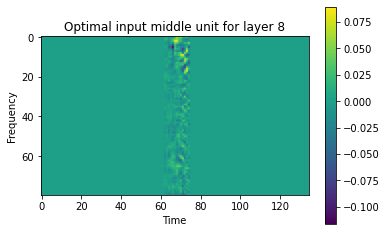

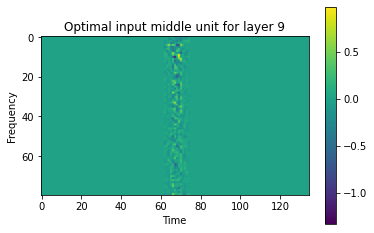

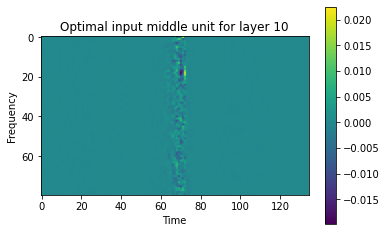

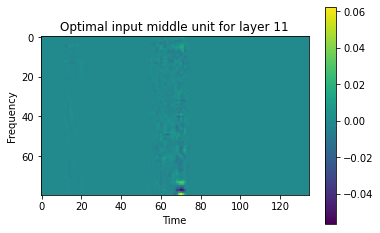

In [8]:
for n,s in enumerate(spect_grad_data):
    plt.figure()
    plt.imshow(s.T)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()

    # plt.title("Gradient")
    plt.title("Optimal input middle unit for layer " + str(n))
    plt.savefig("/scratch/gilbreth/akamsali/Research/Makin/Auditory_Cortex/plots/middle_unit_layer_"+str(n))

In [9]:
import pandas as pd
df_list = []
for s in spect_grad_data:
    df_list.append(pd.DataFrame(s))
pd.concat(df_list, axis=1).to_csv('/scratch/gilbreth/akamsali/Research/Makin/Auditory_Cortex/savefile.csv', index=False)

In [10]:
pd.read_csv('/scratch/gilbreth/akamsali/Research/Makin/Auditory_Cortex/savefile.csv')

,0,1,2,3,4,5,6,7,8,9,...,70.11,71.11,72.11,73.11,74.11,75.11,76.11,77.11,78.11,79.11
0,9.545169e-04,-0.001229,-0.000740,-0.001590,-0.001912,-0.003666,-0.002708,-0.004797,-0.005262,-0.004295,...,0.000009,0.000003,1.328051e-06,-0.000007,-0.000008,3.468613e-06,-0.000007,-2.528514e-05,-0.000021,0.000011
1,-1.600288e-03,0.000268,-0.000024,-0.000832,0.000524,0.000546,0.002864,0.002374,0.004000,0.003956,...,0.000037,0.000005,-1.079619e-05,-0.000002,-0.000010,-9.875504e-06,-0.000008,-2.440196e-05,-0.000011,-0.000006
2,9.323121e-07,-0.000889,-0.000615,-0.000661,0.000037,-0.003899,-0.002354,-0.004397,-0.005230,-0.002003,...,-0.000025,0.000041,-4.579183e-07,-0.000037,0.000016,-2.737233e-05,-0.000006,-8.256971e-06,0.000003,0.000014
3,-1.600288e-03,0.000268,-0.000024,-0.000832,0.000524,0.000546,0.002864,0.002374,0.004000,0.003956,...,-0.000022,-0.000007,8.047533e-07,0.000028,0.000005,2.736685e-06,0.000026,-4.229660e-07,-0.000008,0.000055
4,9.323121e-07,-0.000889,-0.000615,-0.000661,0.000037,-0.003899,-0.002354,-0.004397,-0.005230,-0.002003,...,0.000028,0.000010,-5.972231e-06,-0.000040,-0.000018,2.796923e-05,0.000028,6.715847e-06,-0.000028,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,9.323121e-07,-0.000889,-0.000615,-0.000661,0.000037,-0.003899,-0.002354,-0.004397,-0.005230,-0.002003,...,0.000029,0.000018,-1.730912e-05,-0.000005,0.000012,-1.770940e-05,-0.000005,1.378744e-05,-0.000006,0.000014
131,-1.600288e-03,0.000268,-0.000024,-0.000832,0.000524,0.000546,0.002864,0.002374,0.004000,0.003956,...,-0.000008,0.000011,-3.769262e-06,-0.000013,-0.000002,-2.405079e-06,-0.000014,-1.502480e-05,-0.000013,0.000003
132,9.323121e-07,-0.000889,-0.000615,-0.000661,0.000037,-0.003899,-0.002354,-0.004397,-0.005230,-0.002003,...,-0.000030,0.000003,-1.536979e-05,0.000014,0.000013,-1.078109e-05,-0.000003,-5.834191e-06,0.000016,0.000030
133,-1.600288e-03,0.000268,-0.000024,-0.000832,0.000524,0.000546,0.002864,0.002374,0.004000,0.003956,...,0.000009,0.000023,4.075282e-07,-0.000009,-0.000017,-1.602884e-07,-0.000006,-2.440896e-05,0.000009,0.000023


In [11]:
plt.figure(figsize=(15,8))
plt.imshow(spect_grad_data.T)
plt.colorbar()
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Gradient")
plt.show()

AttributeError: 'list' object has no attribute 'T'

<Figure size 1080x576 with 0 Axes>

In [ ]:
s = np.abs(spect.detach().numpy())
s.shape

In [ ]:
# import librosa
# import scipy as sp

# f, t, sci_spect =sp.signal.spectrogram(aud, fs=16000)
# print("scipy",sci_spect.T.shape)
# hf_spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T
# print("hf",hf_spect.shape)
# librosa_spect = librosa.feature.melspectrogram(aud, sr=16000, n_mels=189)
# print("ls",librosa_spect.T.shape)

# librosa_spect_dB = librosa.power_to_db(librosa_spect, ref=np.max) 
# print("ls",librosa_spect_dB.T.shape)

# plt.pcolormesh(t, f, 10*np.log10(sci_spect), shading='gouraud')
# plt.figure()
# plt.specgram(aud, Fs=16000)
# plt.figure()
# plt.imshow(hf_spect)
# plt.figure()
# plt.imshow(librosa_spect.T)
# plt.figure()
# plt.imshow(librosa_spect_dB.T)
# audio_from_loss_prop = librosa.griffinlim(s)
# audio_from_loss_prop.shape

In [ ]:
# y = aud
# S = np.abs(librosa.stft(y))
# # Invert using Griffin-Lim
# y_inv = librosa.griffinlim(S)
# # Invert without estimating phase
# y_istft = librosa.istft(S)

# # fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
# # librosa.display.waveshow(y, sr=sr, color='b', ax=ax[0])
# plt.plot(y)
# plt.title("Orig")
# plt.figure()
# plt.plot(y_inv)
# # plt.plot(audio_from_loss_prop)
# # plt.plot(audio_from_loss_prop)
# plt.title("GriffinLim")
# plt.figure()
# plt.plot(y_istft)
# plt.title("ISTFT")

In [ ]:
# from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor

# model_cg = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
# processor_cg = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")


In [ ]:
# aud = neural_data.audio(12)
# input_features = processor_cg(aud,padding=True, sampling_rate=16000, return_tensors="pt").input_features

# generated_ids = model_cg.generate(inputs=spect.unsqueeze(0))

# transcription = processor_cg.batch_decode(generated_ids)[0]
# transcription

In [ ]:
from gradient_extraction.hook import Hook

hook = Hook(model, layers[3], backward=True)

decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
generated_ids = model(spect.unsqueeze(0), decoder_input_ids=decoder_input_ids)

# transcription = processor_cg.batch_decode(generated_ids)[0]
# transcription

In [ ]:
hook.output_f[0,:,0]

In [ ]:
# from auditory_cortex.dataset import Neural_Data
# import matplotlib.pyplot as plt

# dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
# # dir = '/Users/akshita/Documents/Research/Makin/data'
# subject = '200206'
# neural_data = Neural_Data(dir, subject)

win = 40
sent = 12 

edges, psth = neural_data.psth()
# plt.bar(edges,psth, width=(0.8*win/1000))
# plt.xlim(neural_data.duration(sent))
# #plt.xlabel('Time (s)', fontsize=14)
# plt.ylabel('Spike Counts', fontsize=14)

In [ ]:
plt.bar(edges,psth, width=(0.8*win/1000))
# plt.xlim(neural_data.duration(sent))
plt.title("PSTH")
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Spike Counts', fontsize=14)